In [48]:
import pandas, re, itertools
import numpy as np
import matplotlib.pyplot as plt

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import * 
from nltk.stem.snowball import SnowballStemmer 
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm, datasets, tree
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [49]:
def plot_confusion_matrix(cm, classes, #Функция из документации sklearn
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [9]:
messages = pandas.read_csv("SMSSpamCollection.csv", sep='\t', names=["label", "message"])

def tokenize(text):
    text = text.lower()
    return word_tokenize(text)


In [15]:
messages.groupby('label').describe()

message
label                                                          
ham   count                                                4199
      unique                                               3955
      top                                Sorry, I'll call later
      freq                                                   23
spam  count                                                 638
      unique                                                567
      top     Please call our customer service representativ...
      freq                                                    4

In [16]:
#Тут мы видим, что ham практически в 7 раз более частотный, чем spam. 
#Выборка не сбалансирована, dummy classifier по максимальной частотности будет всем присваивать значение ham
#

In [61]:
message_train, message_test, label_train, label_test = train_test_split(messages['message'], messages['label'], test_size=0.3)
label_test.value_counts()

ham     1269
spam     183
Name: label, dtype: int64

In [62]:
#Точность будет равна 0.88. Такое высокое значение из-за несбалансированности датасета
#Если потом запустить его на корпусе вообще без хама, точность будет 0

In [63]:
spams = messages[messages['label']=='spam']
hams = messages[messages['label']=='ham']
#Сделаем выборку из равного количества спама и хама
train_set = pandas.concat([spams[:300], hams[:300]], ignore_index = True)
test_set = pandas.concat([spams[300:], hams[300:]], ignore_index = True)
train_set.groupby('label').describe()

message
label                                                          
ham   count                                                 300
      unique                                                296
      top     As per your request 'Melle Melle (Oru Minnamin...
      freq                                                    3
spam  count                                                 300
      unique                                                282
      top     Your free ringtone is waiting to be collected....
      freq                                                    2

In [64]:
X_train = list(train_set['message'])
y_train = np.array(train_set['label'])
X_test = list(test_set['message'])
y_test = np.array(test_set['label'])

In [74]:
def nb_classif(bow, m_type, vect_type): #Функция для рассчета по наивному Байесу
    nb_model = MultinomialNB()
    b_train = bow.fit_transform(X_train) 
    nb_model.fit(b_train, y_train)
    b_test = bow.transform(X_test)
    predict = nb_model.predict(b_test)
    matrix = confusion_matrix(y_test, predict)
    print("\n", vect_type, m_type)
    print(classification_report(y_test, predict, target_names=['Ham', 'Spam']))
    plt.figure()
    print("\n", vect_type, m_type)
    plot_confusion_matrix(matrix, classes=['ham', 'spam'])


 Count Vectorizer Токенизация без пунктуации
             precision    recall  f1-score   support

        Ham       0.99      0.97      0.98      3899
       Spam       0.72      0.92      0.81       338

avg / total       0.97      0.97      0.97      4237


 Count Vectorizer Токенизация без пунктуации
Confusion matrix, without normalization
[[3779  120]
 [  27  311]]

 TfIdf Vectorizer Токенизация без пунктуации
             precision    recall  f1-score   support

        Ham       0.99      0.95      0.97      3899
       Spam       0.63      0.94      0.75       338

avg / total       0.97      0.95      0.95      4237


 TfIdf Vectorizer Токенизация без пунктуации
Confusion matrix, without normalization
[[3708  191]
 [  19  319]]


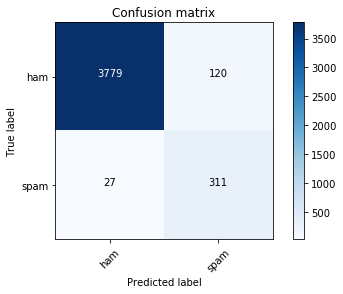

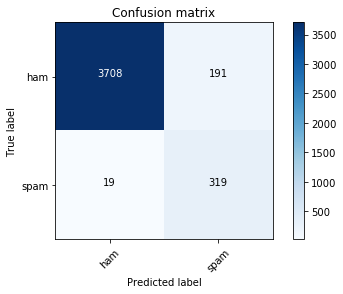

In [76]:
def tokenize_wo_punct(text): #Токенизация без пунктуации
    return word_tokenize(re.sub("[.,!?\(\)\-\:\;\'\"]", "", text.lower())) 

bow = CountVectorizer(analyzer=tokenize_wo_punct)
nb_classif(bow, "Токенизация без пунктуации", "Count Vectorizer")
bow = TfidfVectorizer(analyzer=tokenize_wo_punct)
nb_classif(bow, "Токенизация без пунктуации", "TfIdf Vectorizer")



In [81]:
#В этом случае полнота примерно одинаковая (выше 92%).
#Точность На выделение хама 99% обоими методами
# Точность выделения спама у count vectorizer (72%) выше, чем у tfidf (63%) 
#


 Count Vectorizer Токенизация с пунктуацией
             precision    recall  f1-score   support

        Ham       1.00      0.98      0.99      3899
       Spam       0.78      0.95      0.86       338

avg / total       0.98      0.98      0.98      4237


 Count Vectorizer Токенизация с пунктуацией
Confusion matrix, without normalization
[[3811   88]
 [  17  321]]

 TfIdf Vectorizer Токенизация с пунктуацией
             precision    recall  f1-score   support

        Ham       1.00      0.96      0.98      3899
       Spam       0.65      0.96      0.77       338

avg / total       0.97      0.96      0.96      4237


 TfIdf Vectorizer Токенизация с пунктуацией
Confusion matrix, without normalization
[[3724  175]
 [  15  323]]


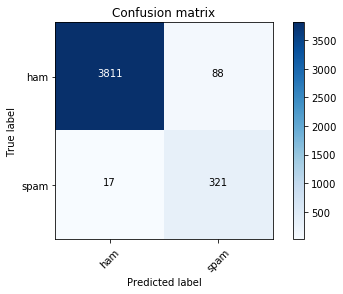

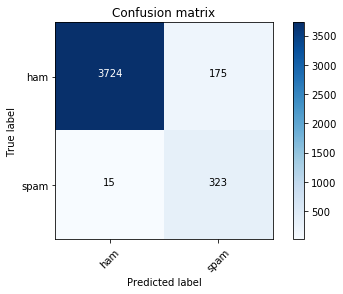

In [77]:
def tokenize_w_punct(text): #Токенизация с пунктуацией
    return wordpunct_tokenize(text.lower()) 
bow = CountVectorizer(analyzer=tokenize_w_punct)
nb_classif(bow, "Токенизация с пунктуацией", "Count Vectorizer")
bow = TfidfVectorizer(analyzer=tokenize_w_punct)
nb_classif(bow, "Токенизация с пунктуацией", "TfIdf Vectorizer")

In [ ]:
#По сравнению с методом без пунктуации все параметры поиска получились выше.
# Разница между count и tfidf такая же, как и в токенизации без пунктуации
# В целом, этот вариант лучше предыдущего
#


 Count Vectorizer Стемминг
             precision    recall  f1-score   support

        Ham       0.99      0.97      0.98      3899
       Spam       0.75      0.93      0.83       338

avg / total       0.97      0.97      0.97      4237


 Count Vectorizer Стемминг
Confusion matrix, without normalization
[[3792  107]
 [  24  314]]

 TfIdf Vectorizer Стемминг
             precision    recall  f1-score   support

        Ham       1.00      0.96      0.98      3899
       Spam       0.65      0.95      0.77       338

avg / total       0.97      0.96      0.96      4237


 TfIdf Vectorizer Стемминг
Confusion matrix, without normalization
[[3727  172]
 [  18  320]]


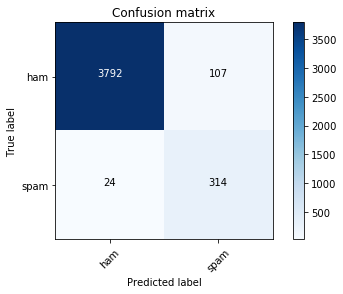

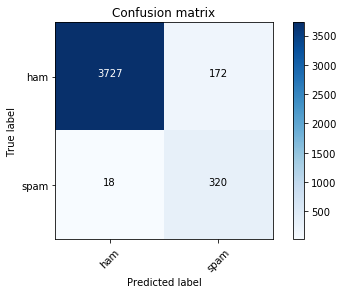

In [78]:
def stemming(text): #Стемминг
    stemmer = SnowballStemmer("english") 
    tokens = word_tokenize(text)
    stemmas = [stemmer.stem(token) for token in tokens]
    return stemmas 
bow = CountVectorizer(analyzer=stemming)
nb_classif(bow, "Стемминг", "Count Vectorizer")
bow = TfidfVectorizer(analyzer=stemming)
nb_classif(bow, "Стемминг", "TfIdf Vectorizer")

In [ ]:
# Стемминг чуть лучше токенизации без пунктуации , но хуже токенизации с пунктуацией
#


 Count Vectorizer Лемматизация
             precision    recall  f1-score   support

        Ham       0.99      0.96      0.98      3899
       Spam       0.68      0.92      0.78       338

avg / total       0.97      0.96      0.96      4237


 Count Vectorizer Лемматизация
Confusion matrix, without normalization
[[3755  144]
 [  28  310]]

 TfIdf Vectorizer Лемматизация
             precision    recall  f1-score   support

        Ham       0.99      0.94      0.97      3899
       Spam       0.58      0.93      0.72       338

avg / total       0.96      0.94      0.95      4237


 TfIdf Vectorizer Лемматизация
Confusion matrix, without normalization
[[3672  227]
 [  22  316]]


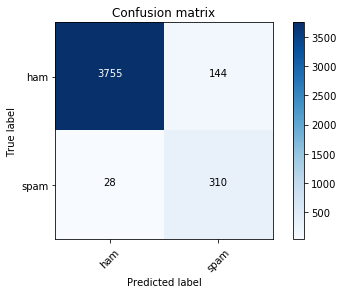

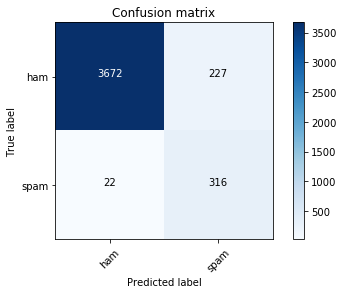

In [79]:
def lemmatising(text): #Лемматизация
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmas
bow = CountVectorizer(analyzer=lemmatising)
nb_classif(bow, "Лемматизация", "Count Vectorizer")
bow = TfidfVectorizer(analyzer=lemmatising)
nb_classif(bow, "Лемматизация", "TfIdf Vectorizer")

In [ ]:
# По точности выделения спама лемматизация проигрывает всем вышеприведенным способам
# Точность выделения хама 99%, полнота выше 92%
#


 Count Vectorizer Стоп-слова
             precision    recall  f1-score   support

        Ham       0.99      0.95      0.97      3899
       Spam       0.62      0.92      0.74       338

avg / total       0.96      0.95      0.95      4237


 Count Vectorizer Стоп-слова
Confusion matrix, without normalization
[[3706  193]
 [  26  312]]

 TfIdf Vectorizer Стоп-слова
             precision    recall  f1-score   support

        Ham       0.99      0.92      0.96      3899
       Spam       0.51      0.94      0.66       338

avg / total       0.96      0.92      0.93      4237


 TfIdf Vectorizer Стоп-слова
Confusion matrix, without normalization
[[3598  301]
 [  21  317]]


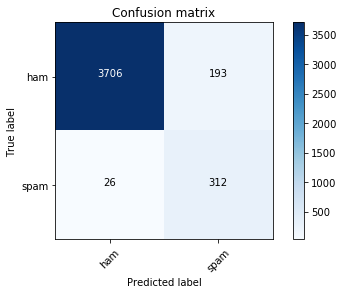

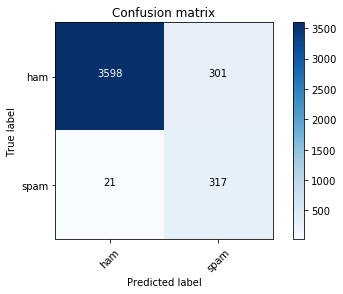

In [80]:
def stop_words(text): #Удаление стоп-слов
    stopWords = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    result = [w for w in tokens if not w in stopWords] 
    return result
bow = CountVectorizer(analyzer=stop_words)
nb_classif(bow, "Стоп-слова", "Count Vectorizer")
bow = TfidfVectorizer(analyzer=stop_words)
nb_classif(bow, "Стоп-слова", "TfIdf Vectorizer")

In [ ]:
# Пожалуй, худший по точности выделения спама метод. 
# Точность для хама и полнота слабо отличаются от других методов. 
#

In [ ]:
#В целом, самым лучшим методом себя показала токенизация с выделением пунктуации в отдельные токены